In [55]:
# import all packages
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import torch.nn as nn
import torch.nn.functional as F
import json
from tqdm import tqdm
import pickle
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from collections import defaultdict

In [56]:
# global variable
embedding_dim = 4096
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("the device being used is", device)

In [57]:
def generate_embeddings(path, file_name, save_kl):
    pretrained_model_name_or_path = '/storage/huggingface_model/gte-Qwen1.5-7B-instruct'
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path, trust_remote_code=True)
    tokenizer.pad_token = tokenizer.eos_token
    model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path, trust_remote_code=True,device_map='auto' )
    print(model.hf_device_map)

    def last_token_pool(last_hidden_states, attention_mask):
        left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
        if left_padding:
            return last_hidden_states[:, -1]
        else:
            sequence_lengths = attention_mask.sum(dim=1) - 1
            batch_size = last_hidden_states.shape[0]
            return last_hidden_states[torch.arange(batch_size, device='cpu'), sequence_lengths]
    
    
    def get_kl_and_embeddings(model, input_texts, save_kl):
        num_tokens = tokenizer(input_texts, return_tensors='pt', truncation=False, padding=False)['input_ids'].shape[1]
        if num_tokens > 300:
            return None

        max_length = 512
        batch_dict = tokenizer(input_texts, max_length=max_length, padding=True, truncation=True, return_tensors='pt')
        with torch.no_grad():
            outputs = model(**batch_dict,output_hidden_states=True)
            if save_kl: 
                last_logits = model.lm_head(outputs.hidden_states[-1]).squeeze()
                first_logits = model.lm_head(outputs.hidden_states[0]).squeeze()
        
        all_embed = [last_token_pool(outputs.hidden_states[i].cpu(), batch_dict['attention_mask']) for i in range(len(outputs.hidden_states))]
        all_embed = torch.concat(all_embed,1).cpu()

        if save_kl: 
            kls = []
            for i in range(1,len(outputs.hidden_states)-1):
                with torch.no_grad():
                    middle_logits = model.lm_head(outputs.hidden_states[i]).squeeze()
                kls.append(F.kl_div(F.log_softmax(middle_logits, dim=-1), F.softmax(first_logits, dim=-1), reduction='batchmean').item()+
                        F.kl_div(F.log_softmax(middle_logits, dim=-1), F.softmax(last_logits, dim=-1), reduction='batchmean').item())
            return kls, all_embed
        
        return all_embed


    with open(path, 'r') as f:
        data = json.load(f)
    if file_name == 'HC3_en_train':
        data = data[:200]
    elif file_name == 'HC3_en_valid':
        data = data[:40]

    kls = []
    embeddings = []
    for text_info in tqdm(data):
        text = text_info['text']
        if save_kl: 
            kl, embedding = get_kl_and_embeddings(model,[text], True)
            if kl is not None :
                kls.append(kl)
                embeddings.append(embedding)
        else :
            embedding = get_kl_and_embeddings(model,[text], False)
            embeddings.append(embedding)
            if kl is not None :
                kls.append(kl)


    save_embed_dir = 'save/embeddings/'
    save_kl_dir = 'save/kl_divergence/'
    # save kl divergence
    if save_kl:
        print(save_embed_dir+file_name+'.pkl')
        pickle.dump(kls, open(save_kl_dir+file_name+'.pkl', 'wb'))

    # save embeddings
    embeddings = torch.cat(embeddings, dim=0)
    print(save_embed_dir+file_name+'.pt')
    torch.save(embeddings, save_embed_dir+file_name+'.pt')

In [58]:
def get_embeddings_and_labels(file_name, data_path, device, layer_num):
    labels = torch.load(f'dataset/labels/' + file_name + '.pt').to(device)
    try:
        embeddings = torch.load(f'save/embeddings/' + file_name + '.pt')             
    except FileNotFoundError:
        # If saved embeddings not found, generate them
        print('target file not found, start generating embeddings')
        generate_embeddings(data_path, file_name, layer_num == -1) #only compute and save kl is layer_num==-1, which means max-kl
        embeddings = torch.load(f'save/embeddings/' + file_name + '.pt') 
    
    if layer_num != -1:
        embeddings = embeddings[:,embedding_dim * layer_num: embedding_dim * (layer_num + 1)].to(device)
    else: #max_kl
        with open(f'save/kl_divergence/' + file_name + '.pkl', 'rb') as f:
            kl = pickle.load(f)
            kl = np.array(kl)
            idx = kl.argmax(axis=1)
            embeddings = torch.tensor([row[(i+1)*embedding_dim:(i+2)*embedding_dim].tolist() for row ,i in zip(embeddings,idx) ]).to(device)

    return embeddings, labels
    

def get_train_eval_data(layer_num, device, train_num = 160, valid_num = 20) :
    train_embeddings, train_labels = get_embeddings_and_labels('HC3_en_train', 'dataset/processed_data/train_valid_data/HC3_en_train.json', device, layer_num)
    valid_embeddings, valid_labels = get_embeddings_and_labels('HC3_en_valid', 'dataset/processed_data/train_valid_data/HC3_en_valid.json', device, layer_num)
    return train_embeddings[:train_num], train_labels[:train_num], valid_embeddings[:valid_num], valid_labels[:valid_num]


In [59]:
# don't edit this cell
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes=[1024, 512], num_labels=2, dropout_prob=0.2):
        super(BinaryClassifier, self).__init__()
        self.num_labels = num_labels
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Dropout(dropout_prob),
                nn.Linear(prev_size, hidden_size),
                nn.Tanh(),
            ])
            prev_size = hidden_size
        self.dense = nn.Sequential(*layers)
        self.classifier = nn.Linear(prev_size, num_labels)
    
    def forward(self, x):
        x = self.dense(x)
        x = self.classifier(x)
        return x

In [96]:
def train(layer_num, device, hidden_sizes = [1024,512], droprate = 0.4, num_epochs = 10, learning_rate = 0.003):
    train_embeddings, train_labels, valid_embeddings, valid_labels = get_train_eval_data(layer_num, device)
    # print(train_embeddings.mean())
    print("there are", train_embeddings.shape[0], "train data and", valid_embeddings.shape[0], "validation data.")
    input_size = train_embeddings.shape[1]
    
    model = BinaryClassifier(input_size,hidden_sizes=hidden_sizes,dropout_prob=droprate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    batch_size = 16
    best_valid_acc = 0
    
    for epoch in range(num_epochs):
        for i in range(0, len(train_embeddings), batch_size):
            model.train()
            batch_embeddings = train_embeddings[i:i+batch_size].to(device)
            batch_labels = train_labels[i:i+batch_size].to(device)
            outputs = model(batch_embeddings)
            loss = criterion(outputs, batch_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            outputs = model(valid_embeddings)
            _, predicted = torch.max(outputs.data, 1)
            accuracy = (predicted == valid_labels).sum().item() / len(valid_labels)
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.4f}")
            
    return model

In [102]:
def get_test_data(device, dataset_names, layer_num) :
    print(layer_num)
    testset_embeddings, testset_labels, data_and_model_names = [], [], []
    for dataset_name in dataset_names: 
        for model_name in ['gpt3.5', 'gpt4', 'claude3']:
            test_embeddings, test_labels = get_embeddings_and_labels(dataset_name + '_' + model_name, 
                'dataset/processed_data/test_data/' + dataset_name + '_' + model_name + '.json', device, layer_num)
            testset_embeddings.append(test_embeddings)
            testset_labels.append(test_labels)
            data_and_model_names.append(dataset_name + "-" + model_name)
    return testset_embeddings, testset_labels, data_and_model_names

def group_and_average(name_to_auroc):
    grouped = defaultdict(list)
    for name, auroc in name_to_auroc.items():
        name_lower = name.lower()
        if 'gpt3' in name_lower or 'chatgpt' in name_lower:
            grouped['gpt3.5'].append(auroc)
        elif 'gpt4' in name_lower:
            grouped['gpt4'].append(auroc)
        elif 'claude' in name_lower:
            grouped['claude3'].append(auroc)
        else:
            print(f"Warning: could not classify {name}")
    
    avg_aurocs = {}
    for model_type in ['gpt3.5', 'gpt4', 'claude3']:
        if grouped[model_type]:
            avg_aurocs[model_type] = sum(grouped[model_type]) / len(grouped[model_type])
        else:
            avg_aurocs[model_type] = None
    
    return avg_aurocs


def run_single_test(model,test_set,test_label,test_acc,testset_name):
    with torch.no_grad():
        outputs = model(test_set)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]
        auroc = roc_auc_score(test_label.cpu().numpy(), probabilities.cpu().numpy())
        test_acc.append(auroc)
    return auroc

def run_all_tests(model, layer_num, device, dataset_names = ['pub', 'writing', 'xsum']) :
    testset_embeddings, testset_labels, data_and_model_names = get_test_data(device, dataset_names, layer_num)
    with torch.no_grad():
        name_to_auroc = {}
        for test_embed, test_label, data_and_model_name in zip(testset_embeddings, testset_labels, data_and_model_names):
            auroc = run_single_test(model, test_embed, test_label, [], ' ')
            name_to_auroc[data_and_model_name] = auroc
    return name_to_auroc

In [103]:
def train_and_test_one_layer(layer_num, device):
    model = train(layer_num, device)
    name_to_auroc = run_all_tests(model, layer_num, device)
    avg_aurocs = group_and_average(name_to_auroc)
    return avg_aurocs

In [104]:
# first layer
avg_aurocs = train_and_test_one_layer(0, device)
print(avg_aurocs)

# last layer
avg_aurocs = train_and_test_one_layer(32, device)
print(avg_aurocs)

the device being used is cuda
there are 160 train data and 20 validation data.
Epoch [1/10], Loss: 0.7425, Validation Accuracy: 0.5000
Epoch [2/10], Loss: 0.7049, Validation Accuracy: 0.5000
Epoch [3/10], Loss: 0.6977, Validation Accuracy: 0.5000
Epoch [4/10], Loss: 0.7065, Validation Accuracy: 0.5000
Epoch [5/10], Loss: 0.7154, Validation Accuracy: 0.5000
Epoch [6/10], Loss: 0.7115, Validation Accuracy: 0.5000
Epoch [7/10], Loss: 0.6729, Validation Accuracy: 0.5000
Epoch [8/10], Loss: 0.8028, Validation Accuracy: 0.5000
Epoch [9/10], Loss: 0.7355, Validation Accuracy: 0.5000
Epoch [10/10], Loss: 0.7553, Validation Accuracy: 0.5000
0
{'gpt3.5': 0.5, 'gpt4': 0.5, 'claude3': 0.5}
the device being used is cuda
there are 160 train data and 20 validation data.
Epoch [1/10], Loss: 0.0034, Validation Accuracy: 1.0000
Epoch [2/10], Loss: 0.0563, Validation Accuracy: 1.0000
Epoch [3/10], Loss: 0.0001, Validation Accuracy: 1.0000
Epoch [4/10], Loss: 0.0325, Validation Accuracy: 1.0000
Epoch [5/1

layer_num = 0
the device being used is cuda
there are 160 train data and 20 validation data.
Epoch [1/10], Loss: 0.7306, Validation Accuracy: 0.5000
Epoch [2/10], Loss: 0.7101, Validation Accuracy: 0.5000
Epoch [3/10], Loss: 0.7105, Validation Accuracy: 0.5000
Epoch [4/10], Loss: 0.6948, Validation Accuracy: 0.5000
Epoch [5/10], Loss: 0.6934, Validation Accuracy: 0.5000
Epoch [6/10], Loss: 0.6686, Validation Accuracy: 0.5000
Epoch [7/10], Loss: 0.6764, Validation Accuracy: 0.5000
Epoch [8/10], Loss: 0.7554, Validation Accuracy: 0.5000
Epoch [9/10], Loss: 0.7095, Validation Accuracy: 0.5000
Epoch [10/10], Loss: 0.7157, Validation Accuracy: 0.5000
0
layer_num = 1
the device being used is cuda
there are 160 train data and 20 validation data.
Epoch [1/10], Loss: 0.4888, Validation Accuracy: 0.8500
Epoch [2/10], Loss: 0.3861, Validation Accuracy: 0.9500
Epoch [3/10], Loss: 0.2804, Validation Accuracy: 0.9500
Epoch [4/10], Loss: 0.0626, Validation Accuracy: 0.9500
Epoch [5/10], Loss: 0.0924,

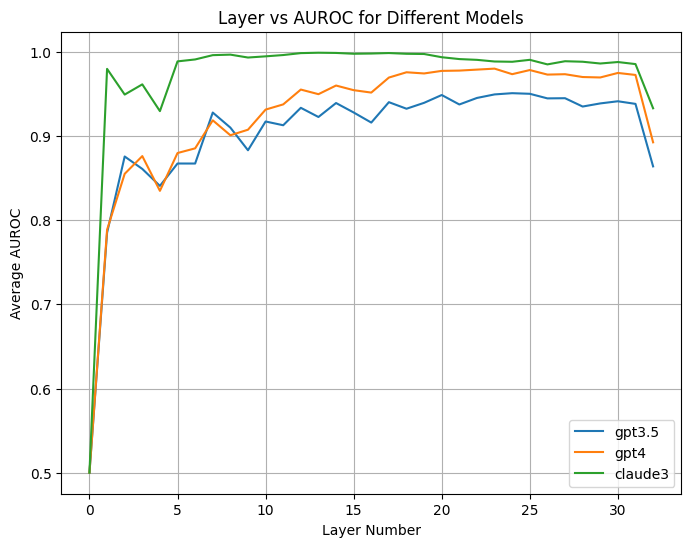

In [110]:
layer_to_aurocs = {'gpt3.5': [], 'gpt4': [], 'claude3': []}
layer_nums = []

for layer_num in range(33):
    print("layer_num =", layer_num)
    layer_nums.append(layer_num)
    avg_aurocs = train_and_test_one_layer(layer_num, device)
    for model_type in ['gpt3.5', 'gpt4', 'claude3']:
        layer_to_aurocs[model_type].append(avg_aurocs[model_type])


# plot (similar to Figure 2 in their paper)
plt.figure(figsize=(8, 6))
for model_type, aucs in layer_to_aurocs.items():
    plt.plot(layer_nums, aucs, label=model_type)

plt.xlabel('Layer Number')
plt.ylabel('Average AUROC')
plt.title('Layer vs AUROC for Different Models')
plt.legend()
plt.grid(True)
plt.show()